In [ ]:
from __future__ import print_function, division

import tensorflow
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv1D
from tensorflow.keras.layers import BatchNormalization, Activation, LayerNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from functools import partial
from tensorflow.keras.utils import plot_model

import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np
import glob
import json

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Import Data.py

In [ ]:
# Add the directory containing the file to the Python path
sys.path.append('G:\My Drive\SJSU\CS298 Research\Code')

import data

# RandomWeightedAverage Class

In [ ]:
class RandomWeightedAverage(Add):
    'Weighted average between real and fake samples'
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

# WGAN Class

In [ ]:
class WGANGP():
    def __init__(self, family, n_critic, alpha, beta_1, beta_2, adam):
        """
        @params:
        family: malware family
        num_unique: number of unique opcodes (used to rescale the data samples between -1 and 1)
        n_critic: critic iterations per generator iteration
        alpha: Adam learning rate
        beta_1, beta_2: Adam 1st and 2nd momentums
        adam: whether to use Adam or RMSProp
        """
        # self.opcode_len = 600
        # self.cols = 1
        self.num_features = 40
        self.sample_shape = (self.num_features,1)
        self.latent_dim = 40
        self.family = family
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.factor = 40/2
        self.n_critic = n_critic

        print('N_critic: %d, Num unique: %d, Factor: %f'%(self.n_critic, num_unique, self.factor))

        if adam:
            print('Using Adam: LR: %f, Beta_1: %f, Beta_2: %f' % (self.alpha, self.beta_1, self.beta_2))
            optimizer = Adam(self.alpha, self.beta_1, self.beta_2)
        else:
            print('Using RMSprop: LR: %f'%self.alpha)
            optimizer = RMSprop(lr=self.alpha)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        ####################################
        """
        Critic graph and compilation
        """
        ####################################

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Real sample input
        real_sample = Input(shape=self.sample_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))

        # Generate fake sample based on noise
        fake_sample = self.generator(z_disc)

        # Ensure generator output shape matches data
        assert fake_sample.shape[1:] == self.sample_shape, "Generator output shape doesn't match data shape"

        # Discriminator determines validity of the real and fake samples
        fake = self.critic(fake_sample)
        valid = self.critic(real_sample)

        # Construct weighted average between real and fake samples
        interpolated_sample = RandomWeightedAverage()([real_sample, fake_sample])

        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_sample)

        # Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_sample)
        partial_gp_loss.__name__ = 'gradient_penalty'

        # Define critic model
        self.critic_model = Model(inputs=[real_sample, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])

        ####################################
        """
        Generator graph and compilation
        """
        ####################################

        # Freeze critic's layers while training generator
        self.critic.trainable = False
        self.generator.trainable = True

        # Noise input
        z_gen = Input(shape=(self.latent_dim,))

        # Generate fake sample based on noise
        fake_sample = self.generator(z_gen)

        # Critic determines validity
        valid = self.critic(fake_sample)

        # Define generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)

    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        L2 norm of Eucledian norm calculation:
        1. Square the gradients
        2. L2 Norm = Sum over rows of squared gradients and take square root
        3. Gradient penalty = lambda*(l2_norm - 1)^2
        """

        # Get gradients wrt interpolated samples
        gradients = K.gradients(y_pred, averaged_samples)[0]

        # Square the gradients
        grad_squared = K.square(gradients)

        # Sum the squared gradients along each row and take square root
        grad_norm = K.sqrt(K.sum(grad_squared,
                                  axis=np.arange(1, len(grad_squared.shape))))

        # Calculate penalty
        grad_penalty = K.square(1 - grad_norm)

        # Return the mean penalty accross the rows
        return K.mean(grad_penalty)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential(name='generator')

        model.add(Input(shape=(self.latent_dim,)))
        # Reshape the input to match the desired shape for Conv1D layers
        model.add(Reshape((self.latent_dim, 1)))

        model.add(Conv1D(64, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv1D(32, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv1D(16, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(np.product(self.sample_shape), activation='tanh'))
        model.add(Reshape(self.sample_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        output = model(noise)

        plot_model(model, to_file='G:\My Drive\SJSU\CS298 Research\Code\wgangp_generator_architecture.png', show_shapes=True)

        return Model(noise, output)

    def build_critic(self):

        model = Sequential(name='critic')
        # Reshape input to match the desired shape for Conv1D layers
        model.add(Reshape((self.sample_shape[0], 1), input_shape=self.sample_shape))
        model.add(Conv1D(64, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(Conv1D(128, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(Conv1D(256, kernel_size=3, activation=LeakyReLU(alpha=0.2), padding="same"))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        inp = Input(shape=self.sample_shape)
        validity = model(inp)

        plot_model(model, to_file='G:\My Drive\SJSU\CS298 Research\Code\wgangp_critic_architecture.png', show_shapes=True)

        return Model(inp, validity)


    def save_model(self, epoch):
      path = 'G:\My Drive\SJSU\CS298 Research\Code\WGANGP_Results\Models_test\Category\%s\%s_generator_%d.hdf5' % (self.family, self.family, epoch)
      self.generator.save(path, include_optimizer=True, save_format='h5')

    def plot_losses(self, results, epochs):
      with open('G:\My Drive\SJSU\CS298 Research\Code\WGANGP_Results\Losses_test\wgangp_%s_loss_values.json'%self.family, "w") as rf:
          print(results)
          json.dump(results, rf)
      print('Plotting.')
      f_d, ax_d = plt.subplots(figsize=(9,6))
      f_g, ax_g = plt.subplots(figsize=(9,6))
      x = [val for val in range(epochs)]
      d = np.array([losses[0] for _,losses in results.items()])
      g = np.array([losses[1] for _,losses in results.items()])
      ax_d.plot(x, d, 'r', label='Critic loss')
      ax_d.set_title('WGAN with Gradient Penalty Critic Loss')
      ax_g.plot(x, g, 'b', label='Generator loss')
      ax_g.set_title('WGAN with Gradient Penalty Generator Loss')
      return f_d, ax_d, f_g, ax_g


    def train(self, X_train, num_unique, epochs, batch_size, model_interval=50):
        factor = num_unique/2
        print('Num unique: %d, Factor: %f'%(num_unique, factor))

        # Load the dataset and rescale to [-1, 1]
        X_train = X_train/factor - 1
        X_train = np.expand_dims(X_train, axis=2)
        print(X_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake =  -np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty

        # Save losses for each epoch for graphs
        results = {}

        for epoch in range(epochs):
            if epoch%400==0:
                self.n_critic=100
            else:
                self.n_critic=10
            for _ in range(self.n_critic):

                ####################################
                """
                Train Critic
                """
                ####################################

                # Select a random batch of real samples
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_samples = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([real_samples, noise],
                                                                [valid, fake, dummy])

            ####################################
            """
            Train Generator
            """
            ####################################

            g_loss = self.generator_model.train_on_batch(noise, valid)

            # # Plot the progress
            # print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            results[epoch] = [np.float64(d_loss[0]), np.float64(g_loss)]
            # If at save interval => save model
            if epoch % model_interval == 0:
              # Plot the progress
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
              self.save_model(epoch)

        print('%d Epochs finished. Saving model in saved_models/' % (epoch))
        return self.plot_losses(results, epochs)

# Malware Categories

In [ ]:
datasetPath = 'G:\My Drive\SJSU\CS298 Research\Code\Dataset\DATASET_SHUFFLED_VirusShare_proportions_and_targets.csv'

## 1. Trojan

Current category: Trojan
N_critic: 10, Num unique: 40, Factor: 0.500000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Instructions for updating:
Colocations handled automatically by placer.
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 40, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 40, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 40, 64)           256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 32)            6176      
                                                                 
 batch_normalization_1 (Batc  (None, 40, 32)      

C:\Users\ranji\AppData\Local\Temp\ipykernel_4988\2775154546.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.generator = self.build_generator()


Num unique: 40, Factor: 20.000000
(6872, 40, 1)
0 [D loss: -6.980657] [G loss: -1.232385]
100 [D loss: -8.086116] [G loss: 4.300638]
200 [D loss: -7.532547] [G loss: 8.045660]
300 [D loss: -5.984499] [G loss: 6.261502]
400 [D loss: -3.350856] [G loss: 4.048792]
500 [D loss: -1.193977] [G loss: 2.244638]
600 [D loss: -0.331293] [G loss: 0.407273]
700 [D loss: -0.028350] [G loss: -3.747951]
800 [D loss: -0.003300] [G loss: -1.595758]
900 [D loss: -0.001266] [G loss: -0.213139]
1000 [D loss: -0.000123] [G loss: 0.566210]
1000 Epochs finished. Saving model in saved_models/
{0: [-6.980656623840332, -1.2323845624923706], 1: [-6.950507640838623, -1.435767650604248], 2: [-7.183171272277832, -1.3107160329818726], 3: [-7.273456573486328, -0.9661668539047241], 4: [-7.382951259613037, -0.5456418395042419], 5: [-7.49489688873291, -0.44297051429748535], 6: [-7.441601276397705, 0.20968765020370483], 7: [-7.634529113769531, 0.3321585953235626], 8: [-7.694672584533691, 0.5253618955612183], 9: [-7.74576

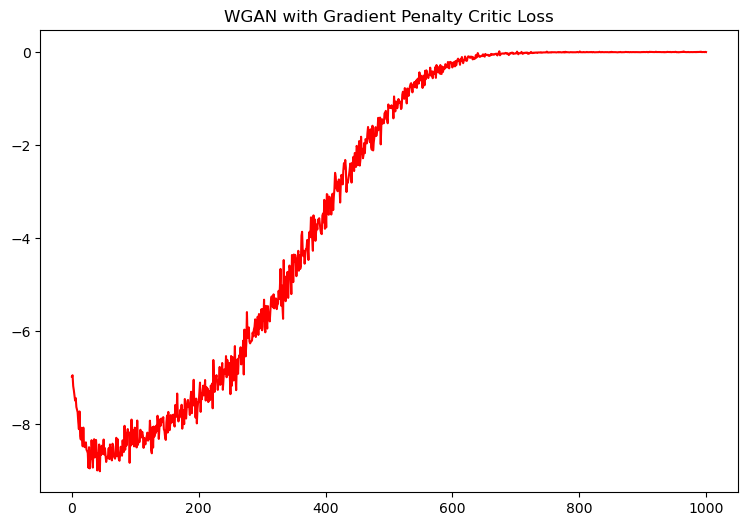

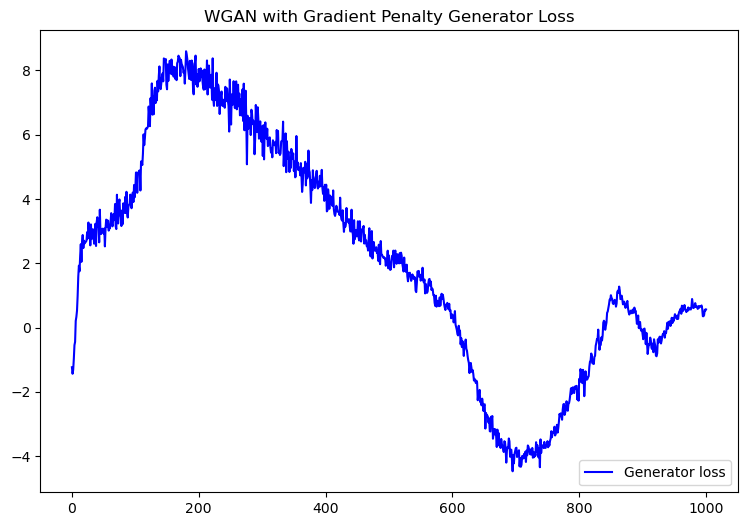

In [ ]:
cat = 'Trojan'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()
gan = WGANGP(cat, 10, 0.0001, 0.5, 0.9, True)
f_d, ax_d, f_g, ax_g = gan.train(data_samples, 40, epochs=1001, batch_size=32, model_interval=100)
plt.legend(loc='lower right')
plt.show()

## 2. Worm

Current category: Worm
N_critic: 10, Num unique: 40, Factor: 0.500000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 40, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 40, 64)            256       
                                                                 
 batch_normalization_3 (Batc  (None, 40, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 40, 32)            6176      
                                                                 
 batch_normalization_4 (Batc  (None, 40, 32)           128       
 hNormalization)                                          

C:\Users\ranji\AppData\Local\Temp\ipykernel_4988\2775154546.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.generator = self.build_generator()


Num unique: 40, Factor: 20.000000
(4397, 40, 1)
0 [D loss: -7.001577] [G loss: -1.488595]
100 [D loss: -8.666896] [G loss: 2.575492]
200 [D loss: -7.267302] [G loss: 2.535108]
300 [D loss: -5.075656] [G loss: 1.470890]
400 [D loss: -2.770588] [G loss: 0.731292]
500 [D loss: -0.914022] [G loss: -1.470845]
600 [D loss: -0.162842] [G loss: -3.761858]
700 [D loss: -0.016613] [G loss: -5.521346]
800 [D loss: -0.001491] [G loss: -0.510506]
900 [D loss: -0.000472] [G loss: -0.352417]
1000 [D loss: -0.000477] [G loss: 0.434948]
1000 Epochs finished. Saving model in saved_models/
{0: [-7.001576900482178, -1.4885947704315186], 1: [-7.313693046569824, -1.2432267665863037], 2: [-7.27713680267334, -1.236870527267456], 3: [-7.412574768066406, -1.1621695756912231], 4: [-7.501810073852539, -0.8654426336288452], 5: [-7.684226989746094, -0.4841768145561218], 6: [-7.739910125732422, 0.022919269278645515], 7: [-7.82590389251709, 0.06381186842918396], 8: [-7.935548782348633, 0.3227105140686035], 9: [-8.024

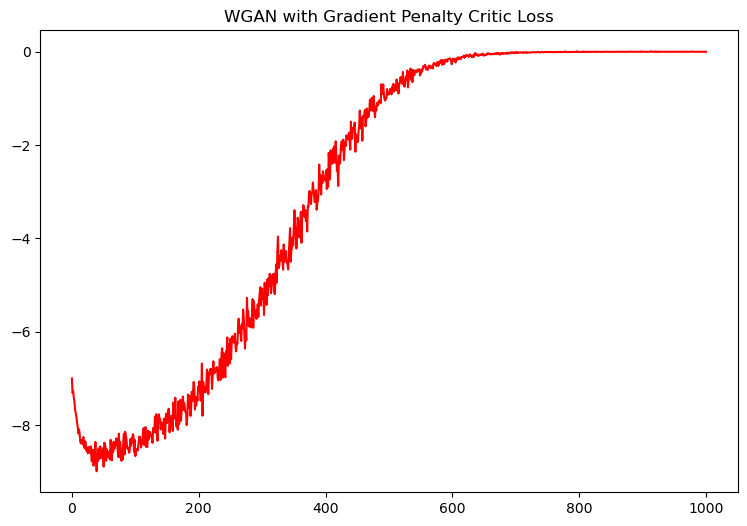

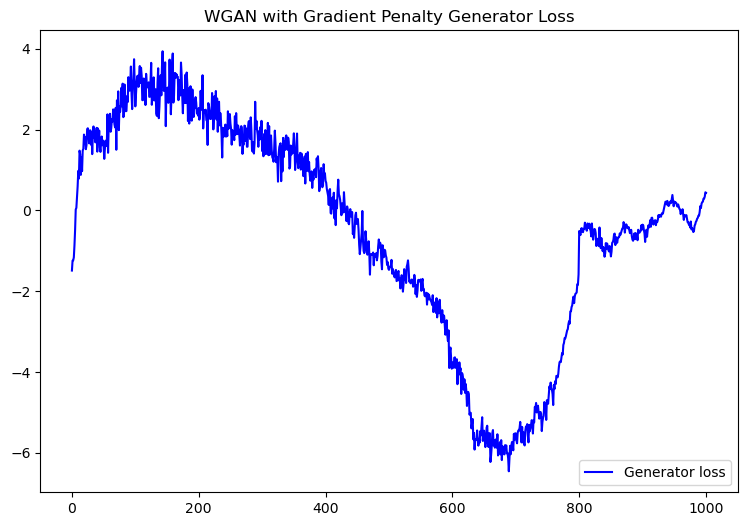

In [ ]:
cat = 'Worm'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()
gan = WGANGP(cat, 10, 0.0001, 0.5, 0.9, True)
f_d, ax_d, f_g, ax_g = gan.train(data_samples, 40, epochs=1001, batch_size=32, model_interval=100)
plt.legend(loc='lower right')
plt.show()

## 3. Password Stealer

Current category: Password Stealer
N_critic: 10, Num unique: 40, Factor: 0.500000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 40, 1)             0         
                                                                 
 conv1d_12 (Conv1D)          (None, 40, 64)            256       
                                                                 
 batch_normalization_6 (Batc  (None, 40, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_13 (Conv1D)          (None, 40, 32)            6176      
                                                                 
 batch_normalization_7 (Batc  (None, 40, 32)           128       
 hNormalization)                              

C:\Users\ranji\AppData\Local\Temp\ipykernel_4988\2775154546.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.generator = self.build_generator()


Num unique: 40, Factor: 20.000000
(4201, 40, 1)
0 [D loss: -7.452661] [G loss: -1.098721]
100 [D loss: -8.410108] [G loss: 6.001818]
200 [D loss: -7.651746] [G loss: 6.588217]
300 [D loss: -6.232251] [G loss: 5.133728]
400 [D loss: -3.454196] [G loss: 2.087389]
500 [D loss: -1.310711] [G loss: 1.577025]
600 [D loss: -0.386273] [G loss: -0.926170]
700 [D loss: -0.038825] [G loss: -5.012567]
800 [D loss: -0.005455] [G loss: -1.641179]
900 [D loss: -0.001252] [G loss: 0.258774]
1000 [D loss: 0.003038] [G loss: 0.263496]
1000 Epochs finished. Saving model in saved_models/
{0: [-7.45266056060791, -1.0987207889556885], 1: [-7.339202880859375, -1.2572518587112427], 2: [-7.362579345703125, -1.0386226177215576], 3: [-7.576379299163818, -0.8768503665924072], 4: [-7.734194755554199, -0.2796216309070587], 5: [-7.91832971572876, 0.024196773767471313], 6: [-7.826291561126709, 0.25245288014411926], 7: [-7.919941425323486, 0.5223544239997864], 8: [-8.191770553588867, 1.2463065385818481], 9: [-7.955494

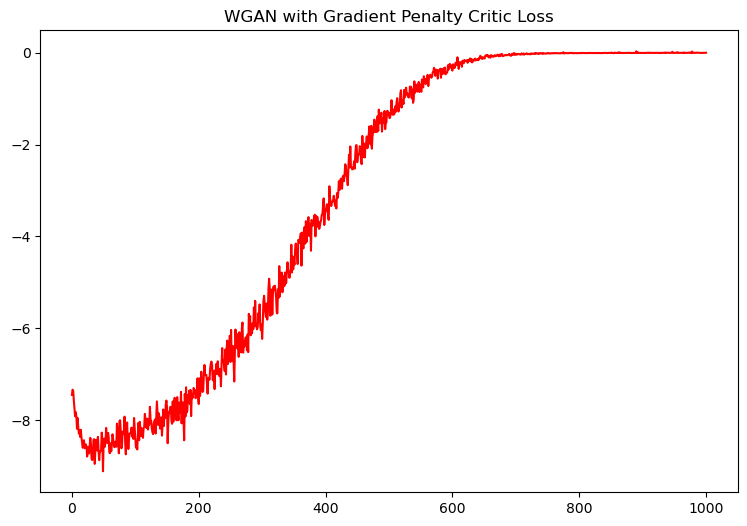

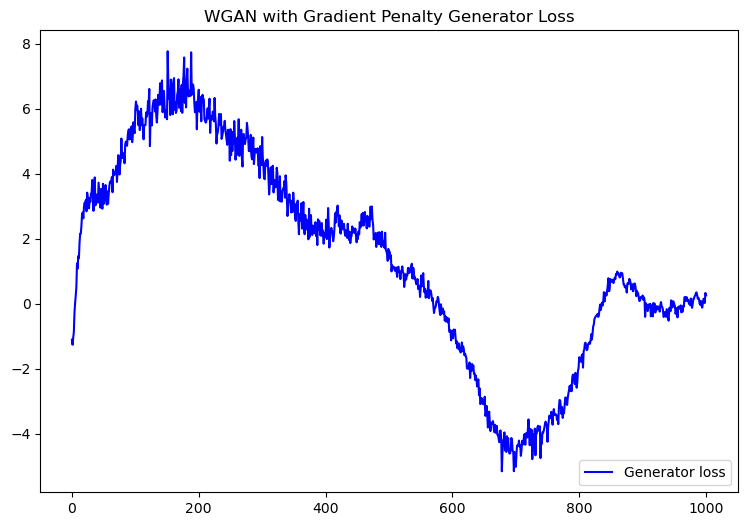

In [ ]:
cat = 'Password Stealer'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()
gan = WGANGP(cat, 10, 0.0001, 0.5, 0.9, True)
f_d, ax_d, f_g, ax_g = gan.train(data_samples, 40, epochs=1001, batch_size=32, model_interval=100)
plt.legend(loc='lower right')
plt.show()

## 4. Tool

Current category: Tool
N_critic: 10, Num unique: 40, Factor: 0.500000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 40, 1)             0         
                                                                 
 conv1d_18 (Conv1D)          (None, 40, 64)            256       
                                                                 
 batch_normalization_9 (Batc  (None, 40, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_19 (Conv1D)          (None, 40, 32)            6176      
                                                                 
 batch_normalization_10 (Bat  (None, 40, 32)           128       
 chNormalization)                                         

C:\Users\ranji\AppData\Local\Temp\ipykernel_4988\2775154546.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.generator = self.build_generator()


Num unique: 40, Factor: 20.000000
(3958, 40, 1)
0 [D loss: -6.692062] [G loss: -0.758450]
100 [D loss: -8.201258] [G loss: 4.815860]
200 [D loss: -7.529482] [G loss: 2.648400]
300 [D loss: -5.918805] [G loss: 0.649762]
400 [D loss: -3.489054] [G loss: 0.274823]
500 [D loss: -1.365310] [G loss: -0.881498]
600 [D loss: -0.394915] [G loss: -2.710469]
700 [D loss: -0.062193] [G loss: -7.564645]
800 [D loss: -0.002780] [G loss: -5.872221]
900 [D loss: 0.000588] [G loss: -1.429229]
1000 [D loss: 0.000711] [G loss: -1.020120]
1000 Epochs finished. Saving model in saved_models/
{0: [-6.6920623779296875, -0.7584503889083862], 1: [-6.934525966644287, -1.0971381664276123], 2: [-6.79353141784668, -0.9652559757232666], 3: [-6.786710262298584, -0.8524051308631897], 4: [-6.846140384674072, -0.6511083841323853], 5: [-6.819416046142578, -0.3088817894458771], 6: [-6.744869709014893, 0.04609173163771629], 7: [-6.841011047363281, 0.31163883209228516], 8: [-6.756650924682617, 0.4049174189567566], 9: [-6.95

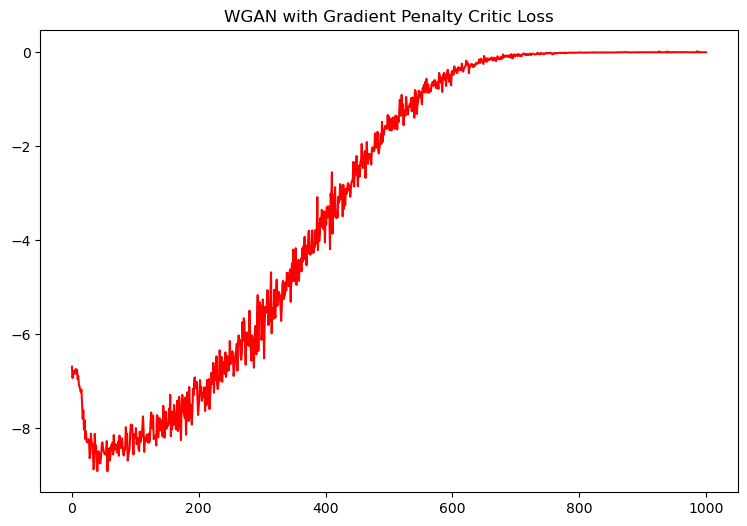

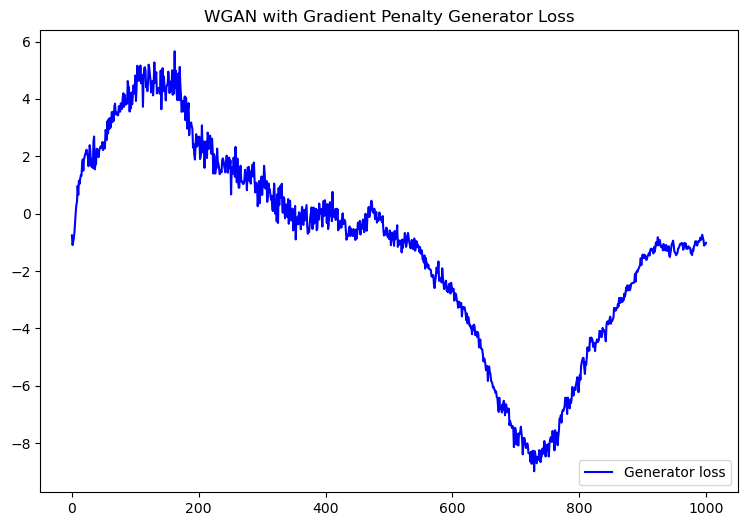

In [ ]:
cat = 'Tool'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()
gan = WGANGP(cat, 10, 0.0001, 0.5, 0.9, True)
f_d, ax_d, f_g, ax_g = gan.train(data_samples, 40, epochs=1001, batch_size=32, model_interval=100)
plt.legend(loc='lower right')
plt.show()

## 5. Trojan Downloader

Current category: Trojan Downloader
N_critic: 10, Num unique: 40, Factor: 0.500000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 40, 1)             0         
                                                                 
 conv1d_24 (Conv1D)          (None, 40, 64)            256       
                                                                 
 batch_normalization_12 (Bat  (None, 40, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_25 (Conv1D)          (None, 40, 32)            6176      
                                                                 
 batch_normalization_13 (Bat  (None, 40, 32)           128       
 chNormalization)                            

C:\Users\ranji\AppData\Local\Temp\ipykernel_4988\2775154546.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.generator = self.build_generator()


Num unique: 40, Factor: 20.000000
(2045, 40, 1)
0 [D loss: -7.420228] [G loss: -1.007564]
100 [D loss: -7.993261] [G loss: 5.974615]
200 [D loss: -7.236385] [G loss: 6.780890]
300 [D loss: -5.331155] [G loss: 5.812809]
400 [D loss: -2.295289] [G loss: 3.284195]
500 [D loss: -0.703555] [G loss: 3.432832]
600 [D loss: -0.117031] [G loss: 0.927919]
700 [D loss: -0.005233] [G loss: -4.708710]
800 [D loss: 0.001517] [G loss: -3.446048]
900 [D loss: -0.000252] [G loss: -2.732497]
1000 [D loss: 0.000313] [G loss: -1.595887]
1000 Epochs finished. Saving model in saved_models/
{0: [-7.420227527618408, -1.0075643062591553], 1: [-6.59494686126709, -1.1093449592590332], 2: [-7.0149946212768555, -0.8479611873626709], 3: [-6.961602210998535, -0.9380792379379272], 4: [-6.968512058258057, -0.7583125829696655], 5: [-7.1076765060424805, -0.5975582599639893], 6: [-7.041552543640137, -0.4067908823490143], 7: [-7.044816017150879, 0.03337404131889343], 8: [-7.058467864990234, 0.4682231545448303], 9: [-7.309

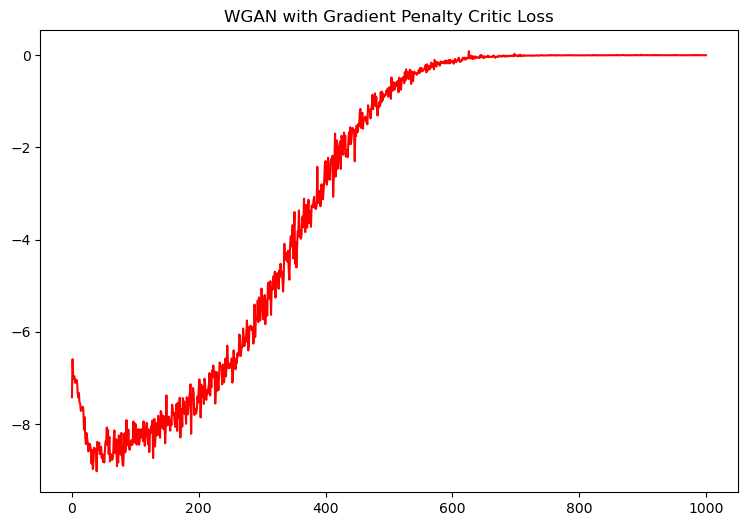

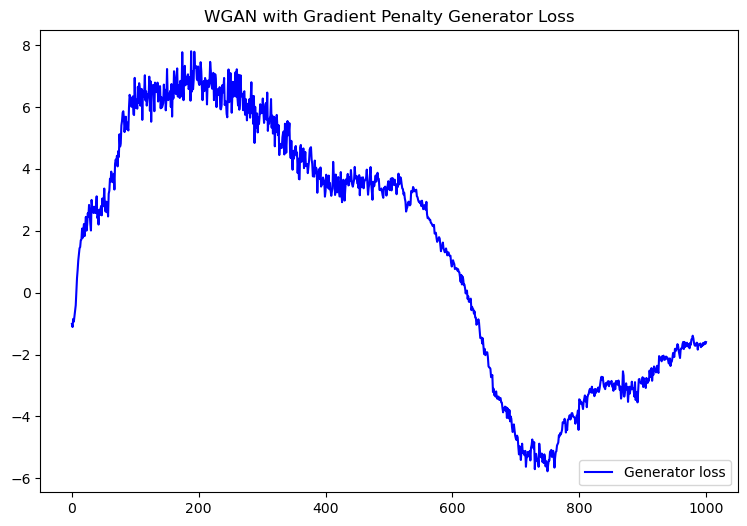

In [ ]:
cat = 'Trojan Downloader'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()
gan = WGANGP(cat, 10, 0.0001, 0.5, 0.9, True)
f_d, ax_d, f_g, ax_g = gan.train(data_samples, 40, epochs=1001, batch_size=32, model_interval=100)
plt.legend(loc='lower right')
plt.show()

## 6. Browser Modifier

Current category: Browser Modifier
N_critic: 10, Num unique: 40, Factor: 0.500000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_15 (Reshape)        (None, 40, 1)             0         
                                                                 
 conv1d_30 (Conv1D)          (None, 40, 64)            256       
                                                                 
 batch_normalization_15 (Bat  (None, 40, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_31 (Conv1D)          (None, 40, 32)            6176      
                                                                 
 batch_normalization_16 (Bat  (None, 40, 32)           128       
 chNormalization)                             

C:\Users\ranji\AppData\Local\Temp\ipykernel_4988\2775154546.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.generator = self.build_generator()


Num unique: 40, Factor: 20.000000
(1815, 40, 1)
0 [D loss: -7.156860] [G loss: -1.020347]
100 [D loss: -8.484571] [G loss: 5.337704]
200 [D loss: -7.519699] [G loss: 5.131506]
300 [D loss: -6.534553] [G loss: 4.802421]
400 [D loss: -3.683066] [G loss: 3.543289]
500 [D loss: -1.980275] [G loss: 2.903356]
600 [D loss: -0.645809] [G loss: 2.846628]
700 [D loss: -0.184052] [G loss: 2.665624]
800 [D loss: -0.036529] [G loss: -1.187259]
900 [D loss: -0.007701] [G loss: 0.195804]
1000 [D loss: -0.003045] [G loss: 2.714170]
1000 Epochs finished. Saving model in saved_models/
{0: [-7.1568603515625, -1.020346760749817], 1: [-7.304724216461182, -0.9724481105804443], 2: [-7.435924530029297, -0.8173549771308899], 3: [-7.640009880065918, -0.47314590215682983], 4: [-7.688691139221191, -0.1662457436323166], 5: [-7.722255229949951, 0.33663082122802734], 6: [-7.878820896148682, 0.6302397847175598], 7: [-7.993309497833252, 0.9712119102478027], 8: [-7.8028388023376465, 1.0178738832473755], 9: [-8.07865047

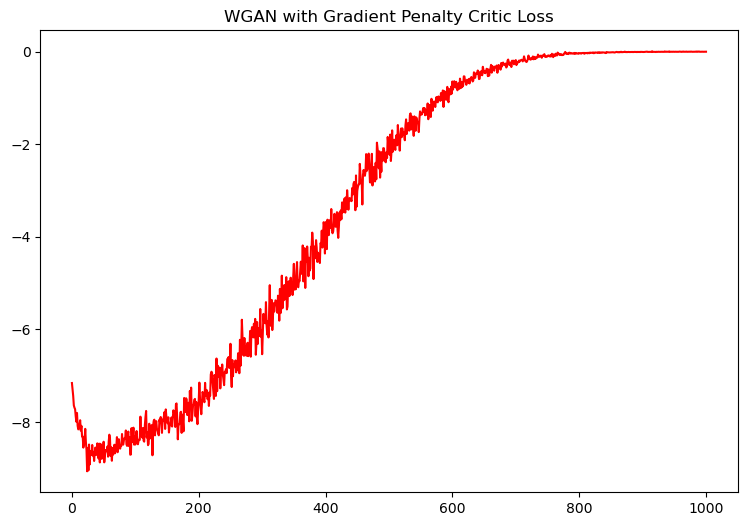

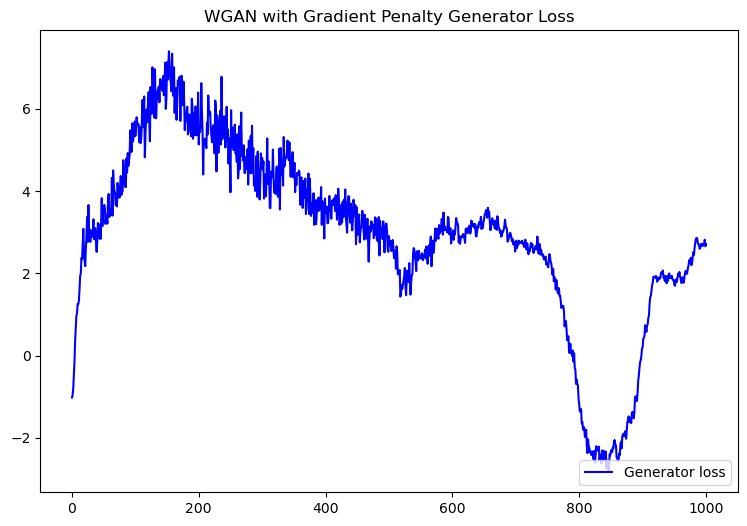

In [ ]:
cat = 'Browser Modifier'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()
gan = WGANGP(cat, 10, 0.0001, 0.5, 0.9, True)
f_d, ax_d, f_g, ax_g = gan.train(data_samples, 40, epochs=1001, batch_size=32, model_interval=100)
plt.legend(loc='lower right')
plt.show()

## 7. Trojan Dropper

Current category: Trojan Dropper
N_critic: 10, Num unique: 40, Factor: 0.500000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_18 (Reshape)        (None, 40, 1)             0         
                                                                 
 conv1d_36 (Conv1D)          (None, 40, 64)            256       
                                                                 
 batch_normalization_18 (Bat  (None, 40, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_37 (Conv1D)          (None, 40, 32)            6176      
                                                                 
 batch_normalization_19 (Bat  (None, 40, 32)           128       
 chNormalization)                               

C:\Users\ranji\AppData\Local\Temp\ipykernel_4988\2775154546.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.generator = self.build_generator()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_20 (Reshape)        (None, 40, 1)             0         
                                                                 
 conv1d_39 (Conv1D)          (None, 40, 64)            256       
                                                                 
 conv1d_40 (Conv1D)          (None, 40, 128)           24704     
                                                                 
 conv1d_41 (Conv1D)          (None, 40, 256)           98560     
                                                                 
 flatten_13 (Flatten)        (None, 10240)             0         
                                                                 
 dense_13 (Dense)            (None, 1)     

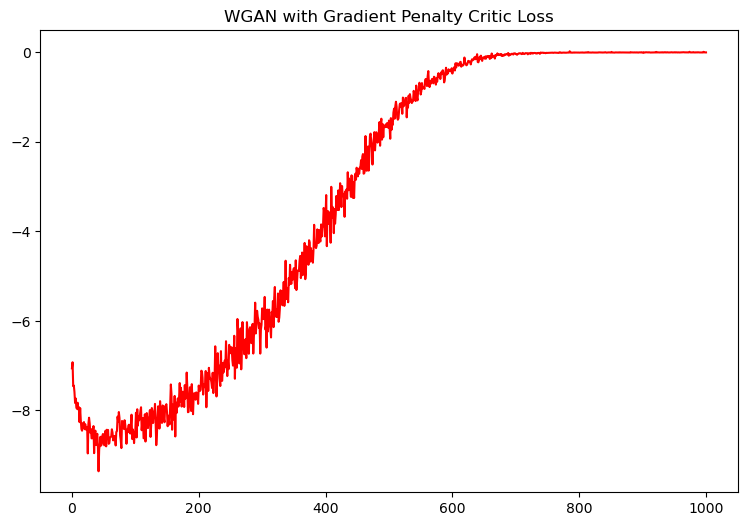

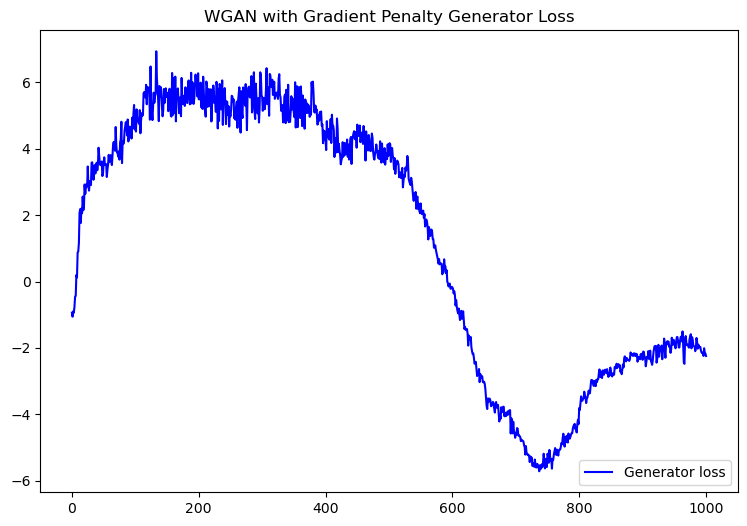

In [ ]:
cat = 'Trojan Dropper'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()
gan = WGANGP(cat, 10, 0.0001, 0.5, 0.9, True)
f_d, ax_d, f_g, ax_g = gan.train(data_samples, 40, epochs=1001, batch_size=32, model_interval=100)
plt.legend(loc='lower right')
plt.show()

## 8. Virus

Current category: Virus
N_critic: 10, Num unique: 40, Factor: 0.500000
Using Adam: LR: 0.000100, Beta_1: 0.500000, Beta_2: 0.900000
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_21 (Reshape)        (None, 40, 1)             0         
                                                                 
 conv1d_42 (Conv1D)          (None, 40, 64)            256       
                                                                 
 batch_normalization_21 (Bat  (None, 40, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_43 (Conv1D)          (None, 40, 32)            6176      
                                                                 
 batch_normalization_22 (Bat  (None, 40, 32)           128       
 chNormalization)                                        

C:\Users\ranji\AppData\Local\Temp\ipykernel_4988\2775154546.py:34: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.generator = self.build_generator()


Num unique: 40, Factor: 20.000000
(876, 40, 1)
0 [D loss: -7.351037] [G loss: -0.813902]
100 [D loss: -8.499442] [G loss: 4.210479]
200 [D loss: -7.250373] [G loss: 4.444246]
300 [D loss: -6.204979] [G loss: 4.758153]
400 [D loss: -4.216061] [G loss: 3.387772]
500 [D loss: -2.111350] [G loss: 2.925561]
600 [D loss: -0.617947] [G loss: 1.915931]
700 [D loss: -0.064928] [G loss: -0.558122]
800 [D loss: 0.005059] [G loss: -2.841243]
900 [D loss: -0.001002] [G loss: -0.601248]
1000 [D loss: -0.000077] [G loss: 2.367962]
1000 Epochs finished. Saving model in saved_models/
{0: [-7.35103702545166, -0.8139019012451172], 1: [-6.979281902313232, -0.8592764139175415], 2: [-7.085674285888672, -0.804213285446167], 3: [-7.142088890075684, -0.5604245662689209], 4: [-7.19166374206543, -0.40281885862350464], 5: [-7.333254337310791, -0.15836526453495026], 6: [-7.456353187561035, 0.3140965700149536], 7: [-7.572728157043457, 0.7211059331893921], 8: [-7.5455546379089355, 0.8256335854530334], 9: [-7.6462135

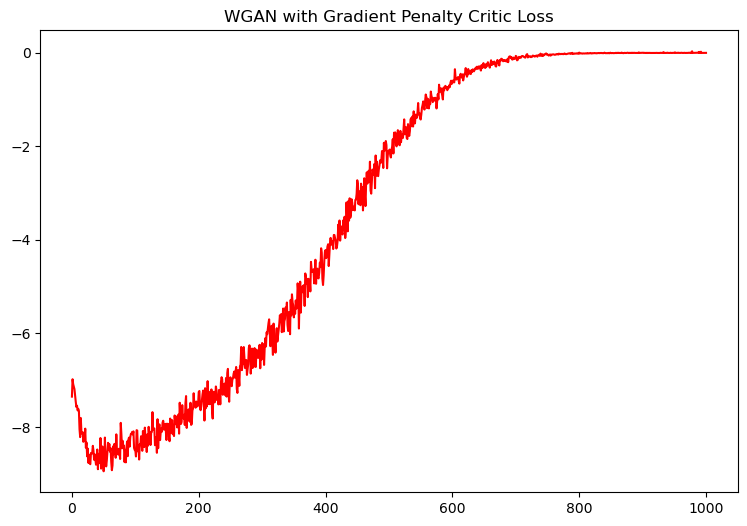

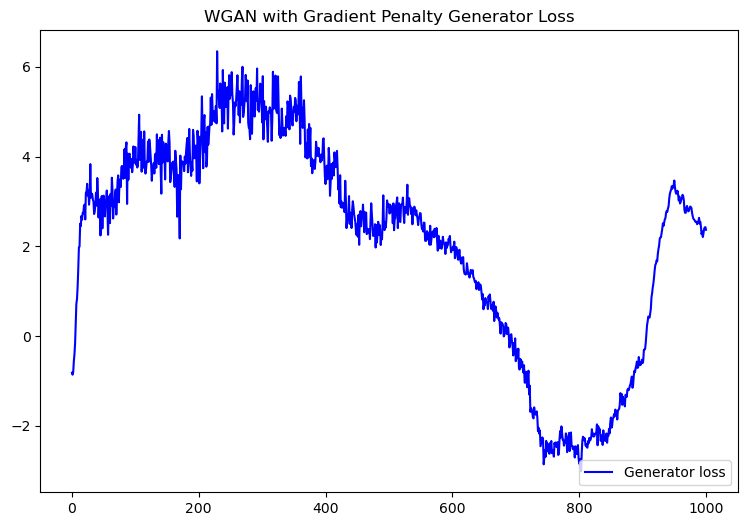

In [ ]:
cat = 'Virus'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()
gan = WGANGP(cat, 10, 0.0001, 0.5, 0.9, True)
f_d, ax_d, f_g, ax_g = gan.train(data_samples, 40, epochs=1001, batch_size=32, model_interval=100)
plt.legend(loc='lower right')
plt.show()

# Generate Fake Samples

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

def generate_fake_samples_from_hdf5(generator_model_path, num_samples, latent_dim):
    """
    Generate fake samples using the generator model saved in HDF5 format.

    Args:
    - generator_model_path: File path to the generator model saved in HDF5 format.
    - num_samples: Number of fake samples to generate.
    - latent_dim: Dimensionality of the latent space.

    Returns:
    - fake_samples: NumPy array containing the generated fake samples.
    """

    # Load the generator model from the HDF5 file
    generator_model = load_model(generator_model_path)

    # Generate random noise as input to the generator
    noise = np.random.normal(0, 1, (num_samples, latent_dim))

    # Generate fake samples using the generator model
    fake_samples = generator_model.predict(noise)

    return fake_samples

def save_fake_samples_to_csv(fake_samples, output_file):
    """
    Save fake samples to a CSV file.

    Args:
    - fake_samples: NumPy array containing the fake samples.
    - output_file: File path to save the CSV file.
    """

    # Convert fake samples to a DataFrame
    df = pd.DataFrame(fake_samples.reshape(fake_samples.shape[0], -1))

    # Save DataFrame to CSV file
    df.to_csv(output_file, index=False)

# Example usage:
# File path to the generator model saved in HDF5 format
Trojan_model_path = "G:\My Drive\SJSU\CS298 Research\Code\WGANGP_Results\Models_test\Category\Trojan\Trojan_generator_1000.hdf5"

# Generate 100 fake samples using the generator model
fake_samples = generate_fake_samples_from_hdf5(Trojan_model_path, num_samples=100, latent_dim=40)

# # Save the fake samples to a CSV file
# output_file = "G:\My Drive\SJSU\CS298 Research\Code\WGANGP_Results\Models_test\Category\Trojan\CSV\Trojan_samples.csv"
# save_fake_samples_to_csv(fake_samples, output_file)

C:\Users\ranji\anaconda3\envs\tensorgpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Convert NumPy array to DataFrame
# Inverse scaling to bring fake samples back to the original range [0, 1]
rescaled_fake_samples = (fake_samples + 1.) /20
df = pd.DataFrame(rescaled_fake_samples.reshape(rescaled_fake_samples.shape[0], -1))

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.000517,0.000331,0.000018,0.000255,0.000027,0.000078,0.000078,0.000031,0.000006,5.841255e-07,...,4.738569e-07,3.281236e-06,2.443790e-07,8.881092e-07,0.000002,1.269579e-06,5.123019e-06,1.376867e-06,2.831221e-07,5.155802e-07
1,0.000086,0.000011,0.000120,0.000013,0.000005,0.000001,0.000233,0.000035,0.000061,1.225769e-05,...,6.854534e-08,7.957220e-07,3.665686e-07,1.195073e-06,0.000007,4.470348e-07,7.450581e-08,1.043081e-07,1.567602e-06,8.344650e-08
2,0.000202,0.000120,0.000611,0.001467,0.000794,0.000150,0.000403,0.000034,0.000014,9.119511e-07,...,8.523464e-07,3.060698e-06,1.311302e-07,5.483627e-07,0.000003,1.078844e-06,8.136034e-07,4.172325e-07,6.794929e-07,1.266599e-06
3,0.001138,0.000437,0.000066,0.000052,0.000019,0.000052,0.000055,0.000051,0.000032,5.045533e-06,...,5.006790e-07,7.331371e-07,2.741814e-07,5.117059e-06,0.000001,1.546741e-06,2.139807e-06,2.226233e-06,1.788139e-07,1.149774e-05
4,0.000332,0.001103,0.000617,0.001310,0.000179,0.000110,0.000020,0.000096,0.000063,1.540780e-06,...,1.132488e-07,6.347894e-07,1.281500e-07,5.298853e-06,0.000011,1.853704e-06,9.363890e-06,6.228685e-07,1.209974e-06,9.983778e-07


In [ ]:
datasetPath = 'G:\My Drive\SJSU\CS298 Research\Code\Dataset\DATASET_SHUFFLED_VirusShare_proportions_and_targets.csv'
cat = 'Trojan'
print('Current category: %s' % (cat))
data_obj = data.DATA(cat, datasetPath)
data_samples, num_unique = data_obj.load_data()

Current category: Trojan


In [ ]:
factor = num_unique/2
# print('Num unique: %d, Factor: %f'%(num_unique, factor))

# Load the dataset and rescale to [-1, 1]
data_samples = data_samples/factor - 1.
df2 = pd.DataFrame(data_samples)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.987036,-0.995667,-0.994718,-0.996705,-0.998281,-0.995678,-0.998693,-0.999427,-0.999139,-0.999774,...,-0.999986,-0.999989,-0.999714,-0.999994,-0.999862,-0.999842,-0.999678,-0.999822,-0.999906,-0.999942
1,-0.994618,-0.996693,-0.997631,-0.998623,-0.998361,-0.999669,-0.998714,-0.998643,-0.999035,-0.999223,...,-0.999706,-0.999530,-0.999468,-0.999321,-0.999611,-0.998719,-0.999547,-0.999672,-0.999738,-0.999846
2,-0.987157,-0.995570,-0.994678,-0.996356,-0.998314,-0.995717,-0.998591,-0.999242,-0.999353,-0.999790,...,-0.999986,-0.999995,-0.999807,-0.999985,-0.999860,-0.999874,-0.999774,-0.999846,-0.999922,-0.999945
3,-0.995300,-0.988113,-0.997112,-0.998302,-0.999003,-0.999159,-0.999122,-0.999029,-0.999136,-0.999232,...,-0.999744,-0.999766,-0.999859,-0.999758,-0.999877,-0.999854,-0.999876,-0.999878,-0.999883,-0.999862
4,-0.994134,-0.998635,-0.995452,-0.997867,-0.998483,-0.999567,-0.998874,-0.998568,-0.998757,-0.998854,...,-0.999644,-0.999609,-0.999823,-0.999632,-0.999841,-0.999759,-0.999831,-0.999817,-0.999818,-0.999793


In [ ]:
resampled_d = (data_samples+1.) * factor
df3 = pd.DataFrame(resampled_d)
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.259273,0.086668,0.105647,0.065893,0.034389,0.086432,0.026133,0.011459,0.017224,0.004517,...,0.000271,0.000218,0.005712,0.000118,0.002768,0.003168,0.006436,0.003568,0.001878,0.001160
1,0.107638,0.066141,0.047376,0.027534,0.032776,0.006614,0.025721,0.027142,0.019303,0.015531,...,0.005879,0.009407,0.010632,0.013571,0.007790,0.025623,0.009064,0.006565,0.005242,0.003087
2,0.256859,0.088595,0.106450,0.072876,0.033722,0.085663,0.028184,0.015167,0.012940,0.004206,...,0.000287,0.000091,0.003866,0.000297,0.002798,0.002515,0.004527,0.003076,0.001562,0.001097
3,0.094007,0.237740,0.057761,0.033955,0.019944,0.016823,0.017553,0.019412,0.017287,0.015351,...,0.005113,0.004670,0.002811,0.004836,0.002457,0.002922,0.002479,0.002446,0.002346,0.002756
4,0.117322,0.027304,0.090950,0.042654,0.030341,0.008655,0.022522,0.028643,0.024866,0.022929,...,0.007125,0.007818,0.003539,0.007364,0.003180,0.004830,0.003371,0.003658,0.003634,0.004136
